In [1]:
import os
!pip install -q kaggle

if not os.path.exists("/root/.kaggle/kaggle.json"):
    from google.colab import files
    print("Upload your kaggle.json file from your Kaggle account")
    files.upload()
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("kaggle.json already configured")

if not os.path.exists("accepted_2007_to_2018Q4.csv.gz"):
    print("Downloading Lending Club dataset...")
    !kaggle datasets download -d wordsforthewise/lending-club -q
    !unzip -q lending-club.zip
    print("Dataset downloaded & extracted")
else:
    print("Dataset already available")

Upload your kaggle.json file from your Kaggle account


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
Dataset downloaded & extracted


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix
)


import warnings

warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv("accepted_2007_to_2018Q4.csv.gz", low_memory=False, nrows=200000)

In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(200000, 151)

In [ ]:
df.info

<bound method DataFrame.info of               id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0       68407277        NaN     3600.0       3600.0           3600.0   
1       68355089        NaN    24700.0      24700.0          24700.0   
2       68341763        NaN    20000.0      20000.0          20000.0   
3       66310712        NaN    35000.0      35000.0          35000.0   
4       68476807        NaN    10400.0      10400.0          10400.0   
...          ...        ...        ...          ...              ...   
199995  56080425        NaN    12000.0      12000.0          12000.0   
199996  55909672        NaN    21000.0      21000.0          21000.0   
199997  54414556        NaN    27500.0      27500.0          27500.0   
199998  56109383        NaN     7000.0       7000.0           7000.0   
199999  56129522        NaN    23000.0      23000.0          23000.0   

              term  int_rate  installment grade sub_grade  ...  \
0        36 months     13.99       123.03     C        C4  ...   
1        36 months     11.99       820.28     C        C1  ...   
2        60 months     10.78       432.66     B        B4  ...   
3        60 months     14.85       829.90     C        C5  ...   
4        60 months     22.45       289.91     F        F1  ...   
...            ...       ...          ...   ...       ...  ...   
199995   36 months     12.69       402.54     C        C2  ...   
199996   36 months     12.29       700.42     C        C1  ...   
199997   60 months     14.65       649.19     C        C5  ...   
199998   36 months     10.99       229.14     B        B4  ...   
199999   60 months     13.99       535.06     C        C4  ...   

       hardship_payoff_balance_amount hardship_last_payment_amount  \
0                                 NaN                          NaN   
1                                 NaN                          NaN   
2                                 NaN                          NaN   
3                                 NaN                          NaN   
4                                 NaN                          NaN   
...                               ...                          ...   
199995                            NaN                          NaN   
199996                            NaN                          NaN   
199997                            NaN                          NaN   
199998                            NaN                          NaN   
199999                            NaN                          NaN   

       disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
0                     Cash                     N                       NaN   
1                     Cash                     N                       NaN   
2                     Cash                     N                       NaN   
3                     Cash                     N                       NaN   
4                     Cash                     N                       NaN   
...                    ...                   ...                       ...   
199995                Cash                     N                       NaN   
199996                Cash                     N                       NaN   
199997                Cash                     N                       NaN   
199998                Cash                     N                       NaN   
199999                Cash                     N                       NaN   

       settlement_status settlement_date settlement_amount  \
0                    NaN             NaN               NaN   
1                    NaN             NaN               NaN   
2                    NaN             NaN               NaN   
3                    NaN             NaN               NaN   
4                    NaN             NaN               NaN   
...                  ...             ...               ...   
199995               NaN             NaN               NaN   
199996               NaN            

> **TASK 1**

In [ ]:
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False).head(15)

,0
member_id,100.0000
sec_app_num_rev_accts,100.0000
sec_app_open_act_il,100.0000
sec_app_inq_last_6mths,100.0000
sec_app_open_acc,100.0000
sec_app_mort_acc,100.0000
sec_app_mths_since_last_major_derog,100.0000
sec_app_collections_12_mths_ex_med,100.0000
sec_app_chargeoff_within_12_mths,100.0000
sec_app_fico_range_low,100.0000


In [ ]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,140992
Charged Off,35090
Current,22637
Late (31-120 days),785
In Grace Period,347
Late (16-30 days),148
Default,1


In [ ]:
df['income_to_loan_ratio'] = df['annual_inc'] / (df['loan_amnt'] + 1)
df['installment_to_income_ratio'] = df['installment'] / (df['annual_inc'] + 1)
df['log_annual_inc'] = np.log1p(df['annual_inc'])

In [ ]:
valid_statuses = ['Fully Paid', 'Charged Off', 'Default']
df = df[df['loan_status'].isin(valid_statuses)].copy()

In [ ]:
df['loan_default'] = df['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0
)
df['loan_default'].value_counts(normalize=True)

,proportion
loan_default,
0,0.800713
1,0.199287


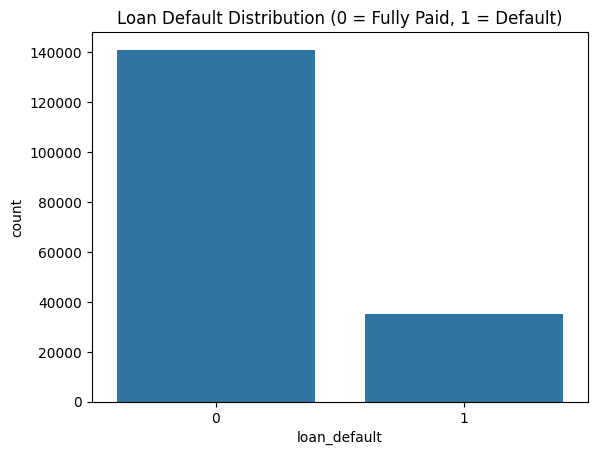

,proportion
loan_default,
0,0.800713
1,0.199287


In [ ]:
# Check class balance
sns.countplot(x='loan_default', data=df)
plt.title("Loan Default Distribution (0 = Fully Paid, 1 = Default)")
plt.show()

df['loan_default'].value_counts(normalize=True)

In [ ]:
selected_features = [
    'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade', 'emp_length', 'home_ownership',
    'annual_inc', 'purpose', 'dti', 'loan_default'
]

df = df[selected_features]

In [ ]:
missing = df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])

emp_length    0.063232
dti           0.000011
dtype: float64


In [ ]:
# Fill numeric columns with median
num_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
cat_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'purpose']
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

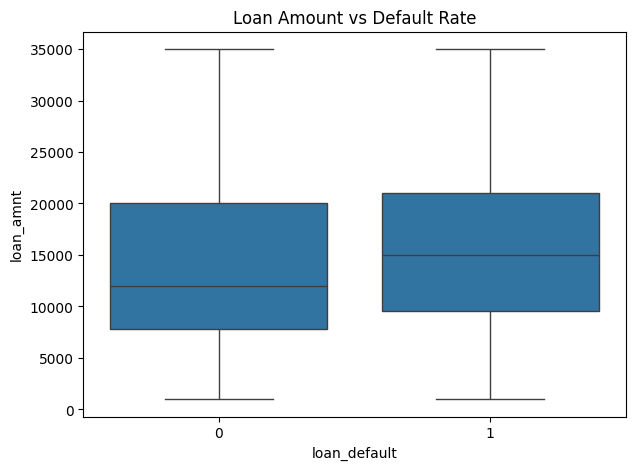

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(x='loan_default', y='loan_amnt', data=df)
plt.title('Loan Amount vs Default Rate')
plt.show()

Observation: Higher loan amounts often → higher default probability.

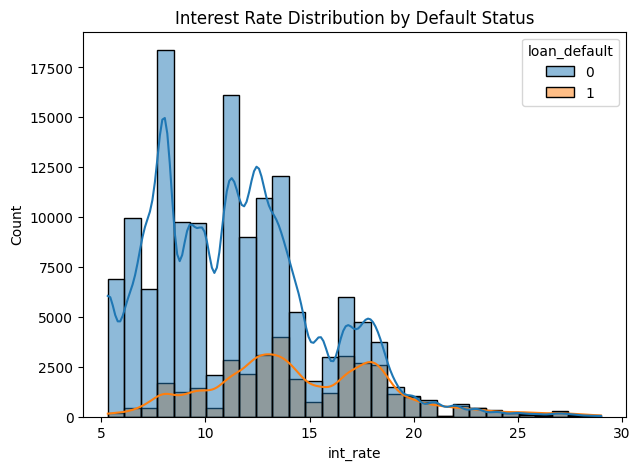

In [ ]:
plt.figure(figsize=(7,5))
sns.histplot(data=df, x='int_rate', hue='loan_default', bins=30, kde=True)
plt.title('Interest Rate Distribution by Default Status')
plt.show()

Defaults are more common for loans with high interest rates.

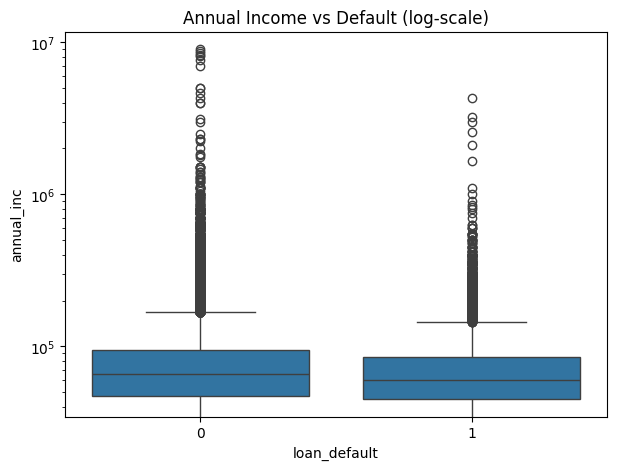

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(x='loan_default', y='annual_inc', data=df)
plt.yscale('log')
plt.title('Annual Income vs Default (log-scale)')
plt.show()

Lower-income applicants tend to default more.

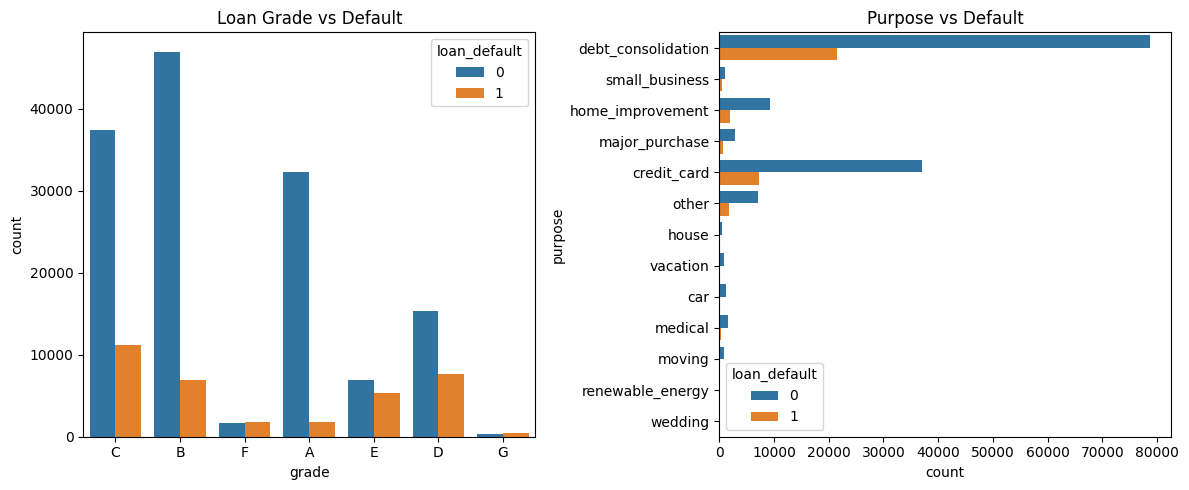

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(x='grade', hue='loan_default', data=df, ax=axes[0])
axes[0].set_title('Loan Grade vs Default')

sns.countplot(y='purpose', hue='loan_default', data=df, ax=axes[1])
axes[1].set_title('Purpose vs Default')
plt.tight_layout()
plt.show()

Certain loan grades (e.g., F, G) and purposes (like small_business, debt_consolidation) have higher default risk.

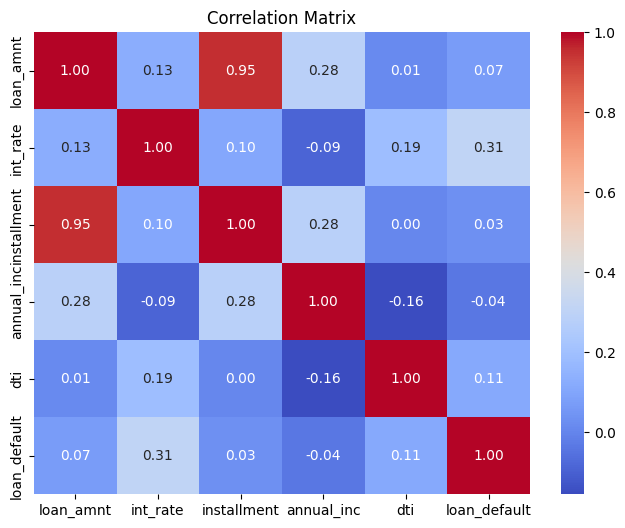

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + ['loan_default']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

| **Insight** | **Business Interpretation** |
|--------------|-----------------------------|
| High interest rate → more defaults | Riskier borrowers are charged more, but also default more |
| Low income & high DTI → more defaults | Financially stressed applicants default easily |
| Longer term loans (60 months) → higher default | More uncertainty over time |
| Lower grade (F, G) → high default | Lending Club’s internal grade works well as a risk proxy |
| Purpose: small business, renewable energy → riskier loans | These are less predictable income sources |


In [ ]:
features = num_cols + cat_cols
X = df[features]
y = df['loan_default']